# Imports

In [1]:
import pandas as pd
from glob import glob
import joblib
from tqdm.auto import tqdm
tqdm.pandas()

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.metrics import f1_score

import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

from typing import List, Tuple, Dict, Sequence, Any

# Create one dataset to rule them all

In [ ]:
JSON_FILES = sorted(glob('*Out.json'))

df = []
for filename in tqdm(JSON_FILES):
    df.append(pd.read_json(filename, lines=True))
df = pd.concat(df)

In [6]:
df.head()

,classes,imports,package,repo
36306,[FlameParticle],"[com.watabou.noosa.particles.Emitter, com.wata...",com.shatteredpixel.shatteredpixeldungeon.effec...,00-Evan/shattered-pixel-dungeon
1791,[ThickPillarsGooRoom],[com.shatteredpixel.shatteredpixeldungeon.acto...,com.shatteredpixel.shatteredpixeldungeon.level...,00-Evan/shattered-pixel-dungeon
32778,[Speck],[com.shatteredpixel.shatteredpixeldungeon.Asse...,com.shatteredpixel.shatteredpixeldungeon.effects,00-Evan/shattered-pixel-dungeon
19332,[Tilemap],"[com.watabou.gltextures.SmartTexture, com.wata...",com.watabou.noosa,00-Evan/shattered-pixel-dungeon
40703,[Elastic],[com.shatteredpixel.shatteredpixeldungeon.acto...,com.shatteredpixel.shatteredpixeldungeon.items...,00-Evan/shattered-pixel-dungeon


In [5]:
df = df.sort_values(by="repo")

In [7]:
joblib.dump(df, "all_data")

['all_data']

# Load the dataset to rule them all into memory

In [2]:
df = joblib.load("all_data")
len(df)

2442145

In [3]:
len(np.unique(df.repo.values))

9998

In [4]:
repo_sizes = {}
for x in df.repo.values:
    repo_sizes[x] = repo_sizes.get(x, 0) + 1
sizes = np.array([x for x in repo_sizes.values()])

In [5]:
np.median(sizes), np.mean(sizes), np.count_nonzero(sizes < 500) / len(sizes)

(39.0, 244.26335267053412, 0.906381276255251)

In [3]:
df = df[:1000000]

# Build the dictionary to quickly access the information

In [4]:
def build_dependency_graph(x, import_g, export_g):
    """
    Populate the dependency graph
    :param x: a file in the dataset from which to extract the new information
    :param import_g: class_j is in import_g[class_i] if class_j is imported in the file where class_i is defined
    :param export_g: reverse of import_g
    """
    if not isinstance(x.package, str):
        return  # this happens rarely, but sometimes package is not defined
    for claz in x.classes:
        # there might be several classes defined in the file
        defined_class = x.package + '.' + claz
        if defined_class not in import_g:
            import_g[defined_class] = {}
        # there might be several classes imported in the file
        for imported_class in x.imports:
            if imported_class not in export_g:
                export_g[imported_class] = {}
            export_g[imported_class][defined_class] = True
            import_g[defined_class][imported_class] = True

In [5]:
import_g = {}
export_g = {}
df.progress_apply(lambda x:build_dependency_graph(x, import_g, export_g), axis=1)

36306    None
1791     None
32778    None
19332    None
40703    None
41354    None
18924    None
3807     None
80284    None
11148    None
49052    None
47001    None
18103    None
4492     None
59104    None
11367    None
30595    None
1952     None
17434    None
30936    None
47477    None
9512     None
29981    None
30975    None
2217     None
87279    None
38883    None
76438    None
77042    None
38224    None
         ... 
53475    None
32403    None
76403    None
48256    None
82768    None
87611    None
59372    None
23167    None
87638    None
49437    None
1996     None
75795    None
88300    None
15479    None
78824    None
76514    None
48000    None
56558    None
78720    None
81985    None
46570    None
58023    None
13200    None
43508    None
8656     None
73167    None
30730    None
30613    None
3387     None
15200    None
Length: 1000000, dtype: object

In [6]:
total_edges = sum([len(import_g[x].keys()) for x in import_g.keys()])
print("Mean vertex degree: ", total_edges/len(df))

Mean vertex degree:  12.19495


In [7]:
def collect_repository_data(x, ctr, rtc):
    """
    Populate the dictionary that allows to quickly query the repository in which a given class is defined as well as
    to see all the classes defined in a given repository
    :param x: a file in the dataset from which to extract the new information
    :param ctr: class to repository. ctr[class1] = [repo1, repo2], list of repositories in which this class is defined
    :param rtc: a dictionary that gives the list of classes in a reository
    """
    if x.repo not in rtc:
        rtc[x.repo] = []
    if not isinstance(x.package, str):
        return # this happens rarely, but sometimes package is not defined
    for claz in x.classes:
        full_name = x.package + '.' + claz
        rtc[x.repo].append(full_name)
        if full_name not in ctr:
            ctr[full_name] = [x.repo]
        elif x.repo not in ctr[full_name]:
            # print(class_name, class_to_repo[class_name], x.repo)
            ctr[full_name].append(x.repo)

In [8]:
ctr = {}  # class to repo
rtc = {}  # repo to class
df.progress_apply(lambda x:collect_repository_data(x, ctr, rtc), axis=1)

36306    None
1791     None
32778    None
19332    None
40703    None
41354    None
18924    None
3807     None
80284    None
11148    None
49052    None
47001    None
18103    None
4492     None
59104    None
11367    None
30595    None
1952     None
17434    None
30936    None
47477    None
9512     None
29981    None
30975    None
2217     None
87279    None
38883    None
76438    None
77042    None
38224    None
         ... 
53475    None
32403    None
76403    None
48256    None
82768    None
87611    None
59372    None
23167    None
87638    None
49437    None
1996     None
75795    None
88300    None
15479    None
78824    None
76514    None
48000    None
56558    None
78720    None
81985    None
46570    None
58023    None
13200    None
43508    None
8656     None
73167    None
30730    None
30613    None
3387     None
15200    None
Length: 1000000, dtype: object

# Collect statistics about repositories in which the problem is pertinent

In [9]:
def get_stats(x, stats):
    """
    Find the cases when multiple classes of teh same name are used within a single repository
    :param x: a file in the dataset from which to extract the new information
    :param stats: a dictionary. stats[repository][class_name][package] gives a list of classes defined in the
    repository that import a class_name from a given package
    NOTE: only one defined class per file is considered
    """
    if x.classes == []:
        return  # if no classes are defined in the file, then there is no information to collect
    if not isinstance(x.package, str):
        return # this happens rarely, but sometimes package is not defined
    if x.repo not in stats:
        stats[x.repo] = {}
    for statement in x.imports:  # import statement
        class_name = statement.split('.')[-1]  # the final part of the class name (capitalized)
        package = '.'.join(statement.split('.')[:-1])  # the package from which the class comes
        if class_name not in stats[x.repo]:
            stats[x.repo][class_name] = {package: [x.package + '.' + x.classes[0]]}
        elif package not in stats[x.repo][class_name]:
            stats[x.repo][class_name][package] = [x.package + '.' + x.classes[0]]  # this means that there are multiple classe of the same name
        else:
            stats[x.repo][class_name][package] += [x.package + '.' + x.classes[0]]

In [10]:
stats = {}
df.progress_apply(lambda x:get_stats(x, stats), axis=1)

36306    None
1791     None
32778    None
19332    None
40703    None
41354    None
18924    None
3807     None
80284    None
11148    None
49052    None
47001    None
18103    None
4492     None
59104    None
11367    None
30595    None
1952     None
17434    None
30936    None
47477    None
9512     None
29981    None
30975    None
2217     None
87279    None
38883    None
76438    None
77042    None
38224    None
         ... 
53475    None
32403    None
76403    None
48256    None
82768    None
87611    None
59372    None
23167    None
87638    None
49437    None
1996     None
75795    None
88300    None
15479    None
78824    None
76514    None
48000    None
56558    None
78720    None
81985    None
46570    None
58023    None
13200    None
43508    None
8656     None
73167    None
30730    None
30613    None
3387     None
15200    None
Length: 1000000, dtype: object

In [11]:
# leave only those class_names that appear under different packages in the same repository
for repo in tqdm(stats.keys()):
    # list of classes to keep
    keep = []
    for claz in stats[repo].keys():
        # list of packages that appear at least twice
        packages = [package for package in stats[repo][claz].keys() if len(stats[repo][claz][package]) > 1]
        if len(packages) >= 2:
            keep.append(claz)
    stats[repo] = {claz:stats[repo][claz] for claz in keep}

stats = {repo:stats[repo] for repo in stats.keys() if len(list(stats[repo].keys())) > 0}

In [12]:
len(stats)

1317

# Saving to a .json file

In [13]:
jsonData = {"edges": [], "annotations": [], "targets": []}

In [14]:
np.random.uniform(low=0, high=1, size=(10,))

array([0.25113534, 0.52239438, 0.52121473, 0.09930365, 0.87250098,
       0.33333116, 0.30721237, 0.6497704 , 0.59998641, 0.00301644])

In [15]:
## NOTE THAT THIS GRAPH CONSTRUCTION IS WRONG. EXPORT AND IMORT ARE TREATED AS THE SAME
def add_json_graph(jsonDict, repo):
    node_dict = {}
    edges = []
    count = 1
    for node in rtc[repo]:
        if node not in node_dict and node is not None:
            node_dict[node] = [count, len(import_g.get(node, [])), len(export_g.get(node, []))]
            count += 1
    for node in rtc[repo]:
        for out_node in list(import_g.get(node, {}).keys()) :
            if out_node not in node_dict.keys() and out_node is not None:
                node_dict[out_node] = (count, len(import_g.get(out_node, [])), len(export_g.get(out_node, [])))
                count += 1
            edges.append([node_dict[node][0], 1, node_dict[out_node][0]])
    node_list = sorted([[x[1], x[2]] for x in node_dict.values()], key=lambda x: x[0])
    if len(edges) == 0 or len(node_list) == 1 or len(node_list) > 250:
        # print("Too many\few nodes\edges!!!")
        return
    jsonDict["edges"].append(edges)
    # jsonDict["node_features"].append(node_list)
    jsonDict["annotations"].append([np.random.uniform(0, 1, 10) for x in node_list])
    jsonDict["targets"].append([[len(node_list)/(len(edges)+0.001)]])

In [16]:
for repo in tqdm(np.unique(df.repo.values)):
    add_json_graph(jsonData, repo)
jsonFile = pd.DataFrame(data=jsonData)
len(jsonFile)

2194

In [17]:
jsonFile.head()

,edges,annotations,targets
0,"[[1, 1, 6], [1, 1, 7], [1, 1, 8], [1, 1, 9], [...","[[0.15420072204382196, 0.49703583948322694, 0....",[[0.3999955556049377]]
1,"[[1, 1, 16], [1, 1, 17], [1, 1, 18], [1, 1, 19...","[[0.07717367352770943, 0.313451034433882, 0.04...",[[0.6681584387513957]]
2,"[[1, 1, 4], [1, 1, 5], [1, 1, 6], [1, 1, 7], [...","[[0.05342441943359455, 0.16212290192069811, 0....",[[0.8461213030268067]]
3,"[[1, 1, 91], [1, 1, 36], [1, 1, 92], [1, 1, 69...","[[0.45608553212031877, 0.08136348626041545, 0....",[[0.3009981440825334]]
4,"[[1, 1, 11], [1, 1, 12], [1, 1, 13], [1, 1, 14...","[[0.12526106991294406, 0.6224625165734394, 0.9...",[[0.15882259516120492]]


In [18]:
validData = jsonFile[:(int)(len(jsonFile)/10)]
trainData = jsonFile[(int)(len(jsonFile)/10):]

In [19]:
validData.to_json("gated-graph-neural-network-pytorch/data/code/valid.json", orient="records")
trainData.to_json("gated-graph-neural-network-pytorch/data/code/train.json", orient="records")

# Caclucating F-1 based on path count

In [13]:
def build_graph(repo, rtc, import_g, export_g):
    """
    Build a networkx graph to work with
    :param repo: the repository in question
    :param rtc:  repository to class list map
    :param import_g: class_j is in import_g[class_i] if class_j is imported in the file where class_i is defined
    :param export_g: reverse of import_g
    """
    G=nx.Graph()
    for x in rtc[repo]:
        G.add_node(x)
    for x in rtc[repo]:
        for y in list(import_g.get(x, {}).keys()) + list(export_g.get(x, {}).keys()) :
            if y not in G.nodes:
                G.add_node(y)
            G.add_edge(x, y)
    print("Total nodes\edges", len(G.nodes), "\\", len(G.edges))
    return G

In [14]:
def check_case(G, candidates, curr, cutoff=3):
    # remove any edges connecting the candidates to the current class
    removed_edge = None
    for candidate in candidates:
        if (candidate, curr) in G.edges:
            G.remove_edge(candidate, curr)
            removed_edge = candidate
            break
            
    result = max(candidates, key=lambda x:len(list(nx.all_simple_paths(G, curr, x, cutoff=cutoff))))
            
    # restore removed edges
    if removed_edge is not None:
        G.add_edge(removed_edge, curr)
    else:
        print("There whould have been an edge")
    return result

In [15]:
def check_class(G, claz, class_stats, cutoff=3):
    # should chack beforehand that class_stats only has two keys
    candidates = list(class_stats.keys())
    c_to_id = {candidates[i] + '.' + claz:i for i in range(len(candidates))}
    print("\t\tThe candidates are ", candidates)
    y_true = []
    y_pred = []
    confusion = np.zeros(shape=(len(candidates), len(candidates)), dtype=np.int)
    for candidate in candidates:
        for curr in class_stats[candidate]:
            y_true.append(c_to_id[candidate + '.' + claz])
            y_pred.append(c_to_id[check_case(G, [x + '.' + claz for x in candidates], curr, cutoff=cutoff)])
            confusion[y_true[-1]][y_pred[-1]] += 1
    print("\t\tConfusion matrix:\n\t\t", confusion[0], "\n\t\t", confusion[1])
    return f1_score(y_true, y_pred, average='macro')

In [16]:
def check_repo(repo, stats, rtc, import_g, export_g, cutoff=3):
    G = build_graph(repo, rtc, import_g, export_g)
    print("Graph built")
    summed_f1_score = 0
    classes_seen = 0
    for claz in stats[repo].keys():
        print("\t\tLooking at class ", claz)
        if len(stats[repo][claz]) == 2:
            f_score = check_class(G, claz, stats[repo][claz], cutoff=cutoff)
            print("\t\tF1 score for this class is ", f_score)
            summed_f1_score += f_score
            classes_seen += 1
        else:
            print('\t\tNumber of candidates is ', len(stats[repo][claz]))
    if classes_seen == 0:
        return None
    return summed_f1_score / classes_seen

In [19]:
repos_seen = 0
f1_scores = []
repo_sizes = []
for repo in tqdm(list(stats.keys())[:320]):
    print("Looking at repository ", repo)
    print("N of classes ", len(rtc[repo]))
    f_score = check_repo(repo, stats, rtc, import_g, export_g, cutoff=3)
    print("F1 for this repository is", f_score, "\n\n")
    if f_score is not None:
        f1_scores.append(f_score)
        repo_sizes.append(len(rtc[repo]))
        repos_seen += 1
print("Average F1 score: ", sum(f1_scores) / repos_seen)

Looking at repository  cogroo/cogroo4
N of classes  118
Total nodes\edges 381 \ 1018
Graph built
		Looking at class  assertEquals
		The candidates are  ['junit.framework.Assert', 'org.junit.Assert']
		Confusion matrix:
		 [3 0] 
		 [2 0]
		F1 score for this class is  0.37499999999999994
		Looking at class  Sentence
		Number of candidates is  3
		Looking at class  Token
		The candidates are  ['org.cogroo.entities', 'org.cogroo.text']
		Confusion matrix:
		 [0 3] 
		 [ 0 14]
		F1 score for this class is  0.45161290322580644
		Looking at class  Node
		The candidates are  ['opennlp.tools.formats.ad.ADSentenceStream.SentenceParser', 'org.cogroo.text.tree']
		Confusion matrix:
		 [3 0] 
		 [1 1]
		F1 score for this class is  0.7619047619047619
		Looking at class  Logger
		Number of candidates is  3
		Looking at class  Level
		The candidates are  ['java.util.logging', 'org.apache.uima.util']
		Confusion matrix:
		 [7 0] 
		 [0 3]
		F1 score for this class is  1.0
F1 for this repository is 0.6

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		Confusion matrix:
		 [16  0] 
		 [ 5 11]
		F1 score for this class is  0.8398398398398398
		Looking at class  Label
		The candidates are  ['org.eclipse.swt.widgets', 'org.eclipse.draw2d']
		Confusion matrix:
		 [39  0] 
		 [6 5]
		F1 score for this class is  0.7767857142857143
		Looking at class  FormLayout
		The candidates are  ['org.eclipse.swt.layout', 'com.jgoodies.forms.layout']
		Confusion matrix:
		 [26  0] 
		 [ 0 10]
		F1 score for this class is  1.0
		Looking at class  Rectangle
		The candidates are  ['org.eclipse.draw2d.geometry', 'org.eclipse.swt.graphics']
		Confusion matrix:
		 [31  0] 
		 [11 10]
		F1 score for this class is  0.7472381794078657
		Looking at class  MenuItem
		The candidates are  ['edu.cmu.cs.hcii.cogtool.model', 'org.eclipse.swt.widgets']
		Confusion matrix:
		 [10  0] 
		 [4 3]
		F1 score for this class is  0.7166666666666666
		Looking at class  Color
		The candidates are  ['org.eclipse.swt.graphics', 'java.awt']
		Confusion matrix:
		 [27  0] 
		 [3 6

		Confusion matrix:
		 [ 0 52] 
		 [ 0 78]
		F1 score for this class is  0.37499999999999994
		Looking at class  Call
		The candidates are  ['retrofit2', 'okhttp3']
		Confusion matrix:
		 [48  0] 
		 [2 0]
		F1 score for this class is  0.4897959183673469
		Looking at class  GET
		The candidates are  ['retrofit2.http', 'retrofit.http']
		Confusion matrix:
		 [27  0] 
		 [2 4]
		F1 score for this class is  0.8821428571428571
		Looking at class  Query
		The candidates are  ['retrofit2.http', 'retrofit.http']
		Confusion matrix:
		 [19  0] 
		 [2 4]
		F1 score for this class is  0.875
		Looking at class  R
		Number of candidates is  4
		Looking at class  Assert
		The candidates are  ['junit.framework', 'org.junit']
		Confusion matrix:
		 [43  0] 
		 [32  0]
		F1 score for this class is  0.364406779661017
		Looking at class  Animator
		Number of candidates is  3
		Looking at class  ObjectAnimator
		Number of candidates is  3
		Looking at class  DateFormat
		The candidates are  ['android.tex

		Confusion matrix:
		 [0 4] 
		 [ 1 62]
		F1 score for this class is  0.48062015503875966
		Looking at class  Protein
		The candidates are  ['com.compomics.util.protein', 'com.compomics.util.experiment.biology']
		Confusion matrix:
		 [8 1] 
		 [0 7]
		F1 score for this class is  0.9372549019607843
		Looking at class  Enzyme
		Number of candidates is  3
F1 for this repository is 0.708937528499772 


Looking at repository  comtel2000/jfxvnc
N of classes  112
Total nodes\edges 316 \ 761
Graph built
		Looking at class  VncRenderService
		The candidates are  ['org.jfxvnc.ui.service', 'org.jfxvnc.swing.service']
		Confusion matrix:
		 [6 0] 
		 [1 1]
		F1 score for this class is  0.7948717948717948
F1 for this repository is 0.7948717948717948 


Looking at repository  connectbot/connectbot
N of classes  126
Total nodes\edges 509 \ 2296
Graph built
		Looking at class  Matcher
		The candidates are  ['java.util.regex', 'org.hamcrest']
		Confusion matrix:
		 [4 0] 
		 [1 2]
		F1 score for this

		Confusion matrix:
		 [25 12] 
		 [ 8 30]
		F1 score for this class is  0.7321428571428572
		Looking at class  Executor
		The candidates are  ['java.util.concurrent', 'com.intellij.execution']
		Confusion matrix:
		 [ 2 18] 
		 [ 1 57]
		F1 score for this class is  0.5155279503105591
		Looking at class  log
		The candidates are  ['com.intellij.vcs', 'com.intellij.vcs.log.TimedCommitParser']
		Confusion matrix:
		 [21  0] 
		 [2 0]
		F1 score for this class is  0.47727272727272724
		Looking at class  SoftReference
		The candidates are  ['java.lang.ref', 'com.intellij.reference']
		Confusion matrix:
		 [ 2 24] 
		 [ 0 49]
		F1 score for this class is  0.47306791569086654
		Looking at class  event
		Number of candidates is  4
		Looking at class  PropertyChangeEvent
		The candidates are  ['java.beans', 'kava.beans']
		Confusion matrix:
		 [38  6] 
		 [ 0 28]
		F1 score for this class is  0.9150275373721479
		Looking at class  PropertyChangeListener
		The candidates are  ['java.beans', 'ka

		Confusion matrix:
		 [15  2] 
		 [1 7]
		F1 score for this class is  0.8663101604278075
		Looking at class  CharFilter
		The candidates are  ['com.intellij.codeInsight.lookup', 'com.intellij.openapi.util.text']
		Confusion matrix:
		 [8 0] 
		 [3 0]
		F1 score for this class is  0.4210526315789474
		Looking at class  FileContent
		Number of candidates is  4
		Looking at class  notNull
		The candidates are  ['com.intellij.util.ObjectUtils', 'com.intellij.testFramework.PlatformTestUtil']
		Confusion matrix:
		 [8 2] 
		 [0 2]
		F1 score for this class is  0.7777777777777778
		Looking at class  Window
		The candidates are  ['consulo.ui', 'java.awt']
		Confusion matrix:
		 [7 0] 
		 [2 0]
		F1 score for this class is  0.43750000000000006
		Looking at class  Pass
		The candidates are  ['com.intellij.codeHighlighting', 'com.intellij.openapi.util']
		Confusion matrix:
		 [25  0] 
		 [10  3]
		F1 score for this class is  0.6041666666666666
		Looking at class  TextAttribute
		The candidates a

		Confusion matrix:
		 [3 2] 
		 [ 0 27]
		F1 score for this class is  0.8571428571428571
		Looking at class  Assert
		The candidates are  ['org.junit', 'junit.framework']
		Confusion matrix:
		 [16  0] 
		 [2 0]
		F1 score for this class is  0.47058823529411764
		Looking at class  Lists
		The candidates are  ['com.google.common.collect', 'com.beust.jcommander.internal']
		Confusion matrix:
		 [4 1] 
		 [3 0]
		F1 score for this class is  0.3333333333333333
		Looking at class  util
		The candidates are  ['java', 'com.conveyal.r5.api']
		Confusion matrix:
		 [16  0] 
		 [2 0]
		F1 score for this class is  0.47058823529411764
		Looking at class  Fare
		The candidates are  ['com.conveyal.gtfs.model', 'com.conveyal.r5.api.util']
		Confusion matrix:
		 [6 0] 
		 [3 0]
		F1 score for this class is  0.4
		Looking at class  TestCase
		The candidates are  ['com.conveyal.r5.otp2.speed_test.test', 'junit.framework']
		Confusion matrix:
		 [3 0] 
		 [1 5]
		F1 score for this class is  0.8831168831

		F1 score for this class is  1.0
		Looking at class  LComponent
		Number of candidates is  3
		Looking at class  NumberUtils
		The candidates are  ['org.loon.framework.android.game.utils', 'org.loon.framework.javase.game.utils']
		Confusion matrix:
		 [7 0] 
		 [2 5]
		F1 score for this class is  0.8541666666666667
		Looking at class  StringUtils
		Number of candidates is  3
		Looking at class  LContainer
		The candidates are  ['org.loon.framework.android.game.core.graphics', 'org.loon.framework.javase.game.core.graphics']
		Confusion matrix:
		 [7 0] 
		 [0 6]
		F1 score for this class is  1.0
		Looking at class  FontMetrics
		The candidates are  ['android.graphics.Paint', 'java.awt']
		Confusion matrix:
		 [2 0] 
		 [0 5]
		F1 score for this class is  1.0
		Looking at class  Resources
		The candidates are  ['org.loon.framework.android.game.core.resource', 'org.loon.framework.javase.game.core.resource']
		Confusion matrix:
		 [3 5] 
		 [ 0 15]
		F1 score for this class is  0.70129870

		Confusion matrix:
		 [26  0] 
		 [2 0]
		F1 score for this class is  0.4814814814814815
		Looking at class  Constants
		The candidates are  ['org.eclipse.jgit.lib', 'org.craftercms.studio.api.v2.service.marketplace']
		Confusion matrix:
		 [5 0] 
		 [2 0]
		F1 score for this class is  0.41666666666666663
		Looking at class  AuthenticationException
		Number of candidates is  3
		Looking at class  ContentService
		The candidates are  ['org.craftercms.studio.api.v2.service.content', 'org.craftercms.studio.api.v1.service.content']
		Confusion matrix:
		 [0 2] 
		 [ 0 34]
		F1 score for this class is  0.4857142857142857
		Looking at class  DependencyService
		The candidates are  ['org.craftercms.studio.api.v2.service.dependency', 'org.craftercms.studio.api.v1.service.dependency']
		Confusion matrix:
		 [0 3] 
		 [ 0 11]
		F1 score for this class is  0.44
		Looking at class  Authentication
		The candidates are  ['org.springframework.security.core', 'org.craftercms.studio.impl.v2.service.se

		Confusion matrix:
		 [6 0] 
		 [2 0]
		F1 score for this class is  0.42857142857142855
		Looking at class  DateTimeFormatter
		The candidates are  ['org.joda.time.format', 'java.time.format']
		Confusion matrix:
		 [2 1] 
		 [0 3]
		F1 score for this class is  0.8285714285714285
		Looking at class  Description
		The candidates are  ['org.junit.runner', 'org.hamcrest']
		Confusion matrix:
		 [3 0] 
		 [0 4]
		F1 score for this class is  1.0
		Looking at class  Lock
		The candidates are  ['org.apache.lucene.store', 'java.util.concurrent.locks']
		Confusion matrix:
		 [4 1] 
		 [0 4]
		F1 score for this class is  0.888888888888889
		Looking at class  Builder
		Number of candidates is  3
		Looking at class  QueryCache
		The candidates are  ['org.elasticsearch.index.cache.query', 'org.apache.lucene.search']
		Confusion matrix:
		 [3 2] 
		 [1 2]
		F1 score for this class is  0.6190476190476191
		Looking at class  Streams
		The candidates are  ['org.elasticsearch.common.io', 'org.elasticse

		Confusion matrix:
		 [4 0] 
		 [1 1]
		F1 score for this class is  0.7777777777777778
		Looking at class  BeanUtils
		The candidates are  ['com.ctrip.framework.apollo.common.utils', 'org.springframework.beans']
		Confusion matrix:
		 [32  0] 
		 [2 0]
		F1 score for this class is  0.48484848484848486
		Looking at class  AbstractIntegrationTest
		The candidates are  ['com.ctrip.framework.apollo.biz', 'com.ctrip.framework.apollo.portal']
		Confusion matrix:
		 [10  0] 
		 [6 0]
		F1 score for this class is  0.38461538461538464
		Looking at class  containsString
		The candidates are  ['org.hamcrest.Matchers', 'org.hamcrest.core.StringContains']
		Confusion matrix:
		 [4 0] 
		 [2 0]
		F1 score for this class is  0.4
		Looking at class  StringUtils
		Number of candidates is  3
		Looking at class  ApolloConfig
		The candidates are  ['com.ctrip.framework.apollo.core.dto', 'com.ctrip.framework.apollo.spring.annotation']
		Confusion matrix:
		 [1 8] 
		 [0 3]
		F1 score for this class is  0.

		Confusion matrix:
		 [34  0] 
		 [2 0]
		F1 score for this class is  0.4857142857142857
		Looking at class  GWT
		The candidates are  ['com.google.gwt.core.client', 'com.google.gwt.core.shared']
		Confusion matrix:
		 [ 4 10] 
		 [ 2 15]
		F1 score for this class is  0.5571428571428572
		Looking at class  Method
		The candidates are  ['java.lang.reflect', 'com.sencha.gxt.widget.core.client.form.FormPanel']
		Confusion matrix:
		 [5 0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  ConcurrentHashMap
		The candidates are  ['org.jboss.netty.util.internal', 'java.util.concurrent']
		Confusion matrix:
		 [4 0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  Path
		The candidates are  ['com.google.gwt.editor.client.Editor', 'org.apache.hadoop.fs']
		Confusion matrix:
		 [11  0] 
		 [ 0 16]
		F1 score for this class is  1.0
		Looking at class  ResponseListener
		The candidates are  ['com.taobao.zeus.socket.worker.WorkerHandler', 'com.taobao.zeus.socket.maste

Total nodes\edges 7115 \ 57560
Graph built
		Looking at class  ui
		Number of candidates is  5
		Looking at class  MetaClass
		The candidates are  ['com.haulmont.chile.core.model', 'com.haulmont.chile.core.annotations']
		Confusion matrix:
		 [296   0] 
		 [31 23]
		F1 score for this class is  0.7738216839340435
		Looking at class  MetaProperty
		The candidates are  ['com.haulmont.chile.core.model', 'com.haulmont.chile.core.annotations']
		Confusion matrix:
		 [160   1] 
		 [25 26]
		F1 score for this class is  0.7957610789980731
		Looking at class  Session
		Number of candidates is  3
		Looking at class  entity
		Number of candidates is  3
		Looking at class  global
		The candidates are  ['com.haulmont.cuba.core', 'com.haulmont.cuba.security']
		Confusion matrix:
		 [176   0] 
		 [2 0]
		F1 score for this class is  0.4971751412429378
		Looking at class  Logger
		Number of candidates is  3
		Looking at class  EventListener
		The candidates are  ['org.springframework.context.event', 'co

		Confusion matrix:
		 [2 0] 
		 [1 3]
		F1 score for this class is  0.8285714285714285
		Looking at class  DatePicker
		The candidates are  ['com.haulmont.cuba.gui.components', 'com.haulmont.cuba.desktop.sys.vcl.DatePicker']
		Confusion matrix:
		 [0 3] 
		 [0 2]
		F1 score for this class is  0.28571428571428575
		Looking at class  StreamResource
		The candidates are  ['com.vaadin.server', 'com.haulmont.cuba.gui.components']
		Confusion matrix:
		 [2 2] 
		 [2 1]
		F1 score for this class is  0.41666666666666663
		Looking at class  VLabel
		The candidates are  ['com.vaadin.v7.client.ui', 'com.vaadin.client.ui']
		Confusion matrix:
		 [2 0] 
		 [4 0]
		F1 score for this class is  0.25
		Looking at class  VTextField
		The candidates are  ['com.vaadin.v7.client.ui', 'com.vaadin.client.ui']
		Confusion matrix:
		 [2 0] 
		 [0 3]
		F1 score for this class is  1.0
		Looking at class  Embedded
		The candidates are  ['javax.persistence', 'com.haulmont.cuba.gui.components']
		Confusion matrix:

		Confusion matrix:
		 [28  0] 
		 [3 0]
		F1 score for this class is  0.47457627118644063
		Looking at class  Image
		The candidates are  ['org.eclipse.swt.graphics', 'java.awt']
		Confusion matrix:
		 [41  0] 
		 [2 0]
		F1 score for this class is  0.48809523809523814
		Looking at class  Rectangle
		The candidates are  ['org.eclipse.swt.graphics', 'org.pentaho.di.core.gui']
		Confusion matrix:
		 [37  0] 
		 [4 0]
		F1 score for this class is  0.4743589743589744
		Looking at class  Assert
		The candidates are  ['org.pentaho.di.core.util', 'org.junit']
		Confusion matrix:
		 [2 1] 
		 [1 3]
		F1 score for this class is  0.7083333333333333
		Looking at class  Field
		The candidates are  ['java.lang.reflect', 'com.sforce.soap.partner']
		Confusion matrix:
		 [1 1] 
		 [0 2]
		F1 score for this class is  0.7333333333333334
		Looking at class  Table
		The candidates are  ['org.eclipse.swt.widgets', 'com.healthmarketscience.jackcess']
		Confusion matrix:
		 [18  0] 
		 [4 0]
		F1 score for

		Confusion matrix:
		 [5 4] 
		 [9 0]
		F1 score for this class is  0.21739130434782608
		Looking at class  OnItemClickListener
		Number of candidates is  3
		Looking at class  Point
		The candidates are  ['android.graphics', 'com.marshalchen.common.uimodule.ImageFilter.RadialDistortionFilter']
		Confusion matrix:
		 [64  2] 
		 [4 0]
		F1 score for this class is  0.4776119402985075
		Looking at class  animation
		Number of candidates is  3
		Looking at class  Animation
		The candidates are  ['android.view.animation', 'com.marshalchen.common.uimodule.easyandroidanimations']
		Confusion matrix:
		 [40  0] 
		 [4 0]
		F1 score for this class is  0.47619047619047616
		Looking at class  DAOFactory
		The candidates are  ['com.marshalchen.common.uimodule.standuptimer.dao', 'com.marshalchen.common.usefulModule.standuptimer.dao']
		Confusion matrix:
		 [0 2] 
		 [2 0]
		F1 score for this class is  0.0
		Looking at class  DateFormat
		The candidates are  ['android.text.format', 'java.text']
		

		Confusion matrix:
		 [2 0] 
		 [2 0]
		F1 score for this class is  0.3333333333333333
F1 for this repository is 0.46305483248581086 


Looking at repository  cymcsg/UltimateRecyclerView
N of classes  233
Total nodes\edges 424 \ 2388
Graph built
		Looking at class  R
		Number of candidates is  3
F1 for this repository is None 


Looking at repository  cytoscape/cytoscape-impl
N of classes  2846
Total nodes\edges 4871 \ 43371
Graph built
		Looking at class  HashSet
		The candidates are  ['java.util', 'io.vavr.collection']
		Confusion matrix:
		 [190   0] 
		 [4 0]
		F1 score for this class is  0.49479166666666663
		Looking at class  Map
		The candidates are  ['java.util', 'io.vavr.collection']
		Confusion matrix:
		 [465   0] 
		 [4 0]
		F1 score for this class is  0.49785867237687365
		Looking at class  Set
		The candidates are  ['java.util', 'io.vavr.collection']
		Confusion matrix:
		 [302   0] 
		 [5 0]
		F1 score for this class is  0.49589490968801314
		Looking at class  VisualPro

		Confusion matrix:
		 [1 4] 
		 [1 4]
		F1 score for this class is  0.4505494505494506
		Looking at class  MusicService
		The candidates are  ['com.github.czyzby.autumn.mvc.component.sfx', 'com.github.czyzby.lml.uedi.music']
		Confusion matrix:
		 [18  0] 
		 [2 0]
		F1 score for this class is  0.4736842105263158
		Looking at class  Root
		Number of candidates is  4
		Looking at class  WebSocket
		The candidates are  ['com.github.czyzby.websocket', 'com.neovisionaries.ws.client']
		Confusion matrix:
		 [6 0] 
		 [2 0]
		F1 score for this class is  0.42857142857142855
		Looking at class  Asset
		The candidates are  ['com.github.czyzby.autumn.mvc.stereotype', 'com.github.czyzby.kiwi.util.gdx.asset']
		Confusion matrix:
		 [2 1] 
		 [2 0]
		F1 score for this class is  0.28571428571428575
		Looking at class  View
		The candidates are  ['com.github.czyzby.autumn.mvc.stereotype', 'com.github.czyzby.lml.uedi.views']
		Confusion matrix:
		 [3 4] 
		 [0 8]
		F1 score for this class is  0.7
		L

		Confusion matrix:
		 [14  0] 
		 [2 0]
		F1 score for this class is  0.4666666666666667
		Looking at class  Destination
		The candidates are  ['org.opennaas.extensions.genericnetwork.model.circuit.request', 'org.opennaas.extensions.ofertie.ncl.provisioner.api.model']
		Confusion matrix:
		 [6 1] 
		 [1 4]
		F1 score for this class is  0.8285714285714286
		Looking at class  Source
		Number of candidates is  3
		Looking at class  PrepareAction
		Number of candidates is  4
		Looking at class  RestoreAction
		Number of candidates is  4
		Looking at class  ConfirmAction
		Number of candidates is  4
		Looking at class  ModelElementNotFoundException
		The candidates are  ['org.opennaas.core.resources', 'org.opennaas.extensions.gim.controller']
		Confusion matrix:
		 [4 1] 
		 [3 0]
		F1 score for this class is  0.3333333333333333
		Looking at class  Connection
		The candidates are  ['com.rabbitmq.client', 'java.sql']
		Confusion matrix:
		 [2 0] 
		 [2 0]
		F1 score for this class is  0.333

		Confusion matrix:
		 [10  0] 
		 [2 0]
		F1 score for this class is  0.45454545454545453
		Looking at class  Event
		The candidates are  ['com.google.gwt.user.client', 'javax.enterprise.event']
		Confusion matrix:
		 [7 9] 
		 [ 0 68]
		F1 score for this class is  0.7733133433283359
		Looking at class  EventHandler
		The candidates are  ['org.jboss.errai.ui.shared.api.annotations', 'com.google.gwt.event.shared']
		Confusion matrix:
		 [16  0] 
		 [2 0]
		F1 score for this class is  0.47058823529411764
		Looking at class  Command
		The candidates are  ['org.uberfire.mvp', 'com.google.gwt.user.client']
		Confusion matrix:
		 [92  0] 
		 [2 0]
		F1 score for this class is  0.4946236559139785
		Looking at class  Image
		The candidates are  ['com.google.gwt.user.client.ui', 'org.gwtbootstrap3.client.ui']
		Confusion matrix:
		 [0 3] 
		 [0 3]
		F1 score for this class is  0.3333333333333333
		Looking at class  IsElement
		The candidates are  ['org.jboss.errai.common.client.api', 'org.jbos

		Confusion matrix:
		 [81  0] 
		 [8 0]
		F1 score for this class is  0.47647058823529415
		Looking at class  assertThat
		Number of candidates is  6
		Looking at class  Statement
		The candidates are  ['com.datastax.oss.driver.api.core.cql', 'org.junit.runners.model']
		Confusion matrix:
		 [43  0] 
		 [2 0]
		F1 score for this class is  0.48863636363636365
		Looking at class  ImmutableMap
		The candidates are  ['com.datastax.oss.driver.shaded.guava.common.collect', 'com.google.common.collect']
		Confusion matrix:
		 [99  0] 
		 [2 0]
		F1 score for this class is  0.495
		Looking at class  fail
		Number of candidates is  5
		Looking at class  when
		The candidates are  ['org.mockito.Mockito', 'com.datastax.oss.simulacron.common.stubbing.PrimeDsl']
		Confusion matrix:
		 [91  0] 
		 [13  4]
		F1 score for this class is  0.6571428571428571
		Looking at class  Uninterruptibles
		The candidates are  ['com.datastax.oss.driver.shaded.guava.common.util.concurrent', 'com.google.common.util.c

		Confusion matrix:
		 [13  0] 
		 [1 7]
		F1 score for this class is  0.9481481481481482
		Looking at class  Document
		The candidates are  ['org.w3c.dom', 'org.eclipse.jface.text']
		Confusion matrix:
		 [19  1] 
		 [ 0 10]
		F1 score for this class is  0.9633699633699633
		Looking at class  Statement
		The candidates are  ['net.sf.jsqlparser.statement', 'java.sql']
		Confusion matrix:
		 [4 2] 
		 [ 1 10]
		F1 score for this class is  0.7984189723320158
		Looking at class  ui
		The candidates are  ['org.jkiss.dbeaver', 'org.eclipse']
		Confusion matrix:
		 [27  0] 
		 [27  3]
		F1 score for this class is  0.4242424242424242
		Looking at class  sql
		The candidates are  ['java', 'org.jkiss.dbeaver.model']
		Confusion matrix:
		 [18  2] 
		 [1 7]
		F1 score for this class is  0.8733031674208145
		Looking at class  Array
		The candidates are  ['java.lang.reflect', 'java.sql']
		Confusion matrix:
		 [7 0] 
		 [2 0]
		F1 score for this class is  0.43750000000000006
		Looking at class  Pr

		Confusion matrix:
		 [9 0] 
		 [ 0 12]
		F1 score for this class is  1.0
		Looking at class  Value
		The candidates are  ['org.apache.accumulo.core.data', 'org.apache.flink.types']
		Confusion matrix:
		 [13  0] 
		 [0 7]
		F1 score for this class is  1.0
		Looking at class  GraphElement
		The candidates are  ['org.gradoop.common.model.api.entities', 'org.s1ck.gdl.model']
		Confusion matrix:
		 [37  0] 
		 [3 0]
		F1 score for this class is  0.4805194805194805
		Looking at class  Comparator
		The candidates are  ['java.util', 'org.s1ck.gdl.utils']
		Confusion matrix:
		 [24  0] 
		 [3 5]
		F1 score for this class is  0.8552036199095023
		Looking at class  Neighborhood
		Number of candidates is  3
		Looking at class  Preconditions
		The candidates are  ['com.google.common.base', 'org.apache.flink.util']
		Confusion matrix:
		 [5 1] 
		 [2 5]
		F1 score for this class is  0.7692307692307692
		Looking at class  StringUtils
		The candidates are  ['org.apache.commons.lang3', 'org.apache.c

		Confusion matrix:
		 [8 0] 
		 [0 6]
		F1 score for this class is  1.0
		Looking at class  VERSION_100
		Number of candidates is  6
		Looking at class  Messages
		Number of candidates is  8
		Looking at class  LockFeature
		The candidates are  ['org.deegree.protocol.wfs.lockfeature', 'org.deegree.protocol.wfs.WFSRequestType']
		Confusion matrix:
		 [6 0] 
		 [2 0]
		F1 score for this class is  0.42857142857142855
		Looking at class  Arc
		The candidates are  ['org.deegree.geometry.primitive.segments', 'org.deegree.rendering.r3d.multiresolution']
		Confusion matrix:
		 [14  0] 
		 [0 5]
		F1 score for this class is  1.0
		Looking at class  XPath
		The candidates are  ['org.deegree.commons.xml', 'org.jaxen']
		Confusion matrix:
		 [89  0] 
		 [2 0]
		F1 score for this class is  0.4944444444444444
		Looking at class  LiteralInput
		The candidates are  ['org.deegree.services.wps.input', 'org.deegree.protocol.wps.client.input']
		Confusion matrix:
		 [10  0] 
		 [2 0]
		F1 score for this 

		Confusion matrix:
		 [13  0] 
		 [6 2]
		F1 score for this class is  0.6062500000000001
		Looking at class  Stroke
		The candidates are  ['org.deegree.style.styling.components', 'java.awt']
		Confusion matrix:
		 [11  0] 
		 [2 6]
		F1 score for this class is  0.8869047619047619
		Looking at class  assertNull
		The candidates are  ['junit.framework.Assert', 'org.junit.Assert']
		Confusion matrix:
		 [0 5] 
		 [ 0 11]
		F1 score for this class is  0.4074074074074074
		Looking at class  GetPropertyValue
		The candidates are  ['org.deegree.protocol.wfs.getpropertyvalue', 'org.deegree.protocol.wfs.WFSRequestType']
		Confusion matrix:
		 [10  0] 
		 [3 0]
		F1 score for this class is  0.4347826086956522
		Looking at class  Operation
		The candidates are  ['org.deegree.commons.ows.metadata.operation', 'org.deegree.client.sos.storage.components']
		Confusion matrix:
		 [15  0] 
		 [3 0]
		F1 score for this class is  0.45454545454545453
		Looking at class  ServiceConfiguration
		Number of ca

		Confusion matrix:
		 [1 4] 
		 [6 2]
		F1 score for this class is  0.22619047619047622
		Looking at class  BaseFlatMapFunctionAdaptee
		The candidates are  ['org.datavec.spark.transform', 'org.datavec.local.transforms']
		Confusion matrix:
		 [2 4] 
		 [4 0]
		F1 score for this class is  0.16666666666666666
		Looking at class  ObjectMapper
		The candidates are  ['org.nd4j.shade.jackson.databind', 'com.mashape.unirest.http']
		Confusion matrix:
		 [15  1] 
		 [0 5]
		F1 score for this class is  0.9384164222873901
		Looking at class  ReflectionUtils
		The candidates are  ['org.datavec.api.util', 'org.apache.hadoop.util']
		Confusion matrix:
		 [4 0] 
		 [1 1]
		F1 score for this class is  0.7777777777777778
		Looking at class  io
		The candidates are  ['java', 'org.apache.hadoop']
		Confusion matrix:
		 [24  0] 
		 [3 0]
		F1 score for this class is  0.47058823529411764
		Looking at class  JsonNode
		Number of candidates is  3
		Looking at class  Files
		The candidates are  ['com.googl

		Confusion matrix:
		 [68  0] 
		 [2 0]
		F1 score for this class is  0.49275362318840576
		Looking at class  ArrayUtils
		The candidates are  ['org.apache.commons.lang3', 'org.apache.commons.lang']
		Confusion matrix:
		 [40  0] 
		 [2 0]
		F1 score for this class is  0.4878048780487805
		Looking at class  Loader
		The candidates are  ['org.bytedeco.javacpp', 'org.nd4j.api.loader']
		Confusion matrix:
		 [3 4] 
		 [0 6]
		F1 score for this class is  0.6749999999999999
		Looking at class  Function
		Number of candidates is  4
		Looking at class  Pair
		Number of candidates is  3
		Looking at class  Path
		The candidates are  ['java.nio.file', 'org.apache.hadoop.fs']
		Confusion matrix:
		 [16  0] 
		 [ 1 21]
		F1 score for this class is  0.9732205778717407
		Looking at class  Explanation
		The candidates are  ['org.apache.solr.client.solrj.io.stream.expr', 'org.apache.lucene.search']
		Confusion matrix:
		 [0 2] 
		 [0 2]
		F1 score for this class is  0.3333333333333333
		Looking at c

		Confusion matrix:
		 [9 0] 
		 [3 0]
		F1 score for this class is  0.42857142857142855
		Looking at class  WritableComparator
		The candidates are  ['org.datavec.api.io', 'org.datavec.api.writable.comparator']
		Confusion matrix:
		 [8 1] 
		 [1 1]
		F1 score for this class is  0.6944444444444444
		Looking at class  BatchNormalization
		The candidates are  ['org.deeplearning4j.nn.conf.layers', 'org.deeplearning4j.nn.layers.normalization']
		Confusion matrix:
		 [11  0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  JsonParser
		Number of candidates is  3
		Looking at class  JsonNode
		Number of candidates is  3
		Looking at class  Configuration
		Number of candidates is  5
		Looking at class  ValidationResult
		The candidates are  ['org.deeplearning4j.spark.util.data', 'org.nd4j.validation']
		Confusion matrix:
		 [3 1] 
		 [0 6]
		F1 score for this class is  0.8901098901098901
		Looking at class  LongWritable
		The candidates are  ['org.datavec.api.writable', 'org.a

		Confusion matrix:
		 [7 0] 
		 [2 0]
		F1 score for this class is  0.43750000000000006
		Looking at class  ROC
		The candidates are  ['org.nd4j.evaluation.classification', 'org.deeplearning4j.eval']
		Confusion matrix:
		 [12  0] 
		 [2 0]
		F1 score for this class is  0.4615384615384615
		Looking at class  ReduceOp
		The candidates are  ['org.datavec.api.transform', 'org.nd4j.linalg.api.ops']
		Confusion matrix:
		 [11  0] 
		 [2 3]
		F1 score for this class is  0.8333333333333333
		Looking at class  StepFunction
		The candidates are  ['org.deeplearning4j.nn.conf.stepfunctions', 'org.deeplearning4j.optimize.api']
		Confusion matrix:
		 [3 0] 
		 [ 0 17]
		F1 score for this class is  1.0
		Looking at class  GaussianDistribution
		The candidates are  ['org.deeplearning4j.nn.conf.distribution', 'org.nd4j.linalg.api.ops.random.impl']
		Confusion matrix:
		 [2 4] 
		 [0 7]
		F1 score for this class is  0.6388888888888888
		Looking at class  Util
		Number of candidates is  3
		Looking at 

		Confusion matrix:
		 [18  2] 
		 [9 4]
		F1 score for this class is  0.593505039193729
		Looking at class  blas
		Number of candidates is  3
		Looking at class  ExecutionMode
		The candidates are  ['org.nd4j.autodiff.execution.conf', 'org.nd4j.parameterserver.distributed.enums']
		Confusion matrix:
		 [4 0] 
		 [0 7]
		F1 score for this class is  1.0
		Looking at class  Set
		The candidates are  ['java.util', 'org.nd4j.linalg.api.ops.impl.transforms']
		Confusion matrix:
		 [8 5] 
		 [0 3]
		F1 score for this class is  0.6536796536796536
		Looking at class  ByteArrayOutputStream
		The candidates are  ['java.io', 'org.apache.commons.io.output']
		Confusion matrix:
		 [13  0] 
		 [2 0]
		F1 score for this class is  0.4642857142857143
		Looking at class  Properties
		The candidates are  ['java.util', 'org.bytedeco.javacpp.annotation']
		Confusion matrix:
		 [12  0] 
		 [1 1]
		F1 score for this class is  0.8133333333333334
		Looking at class  impl
		Number of candidates is  4
		Looking 

Total nodes\edges 1018 \ 5922
Graph built
		Looking at class  util
		The candidates are  ['java', 'com.robin.general']
		Confusion matrix:
		 [145   0] 
		 [15  0]
		F1 score for this class is  0.47540983606557374
		Looking at class  swing
		Number of candidates is  3
		Looking at class  event
		The candidates are  ['java.awt', 'javax.swing']
		Confusion matrix:
		 [62  1] 
		 [24  0]
		F1 score for this class is  0.4161073825503355
		Looking at class  RealmBattle
		The candidates are  ['com.robin.magic_realm.RealmBattle', 'com.robin.magic_realm']
		Confusion matrix:
		 [3 0] 
		 [5 0]
		F1 score for this class is  0.2727272727272727
		Looking at class  io
		The candidates are  ['java', 'com.robin.general']
		Confusion matrix:
		 [31  0] 
		 [7 0]
		F1 score for this class is  0.4492753623188405
		Looking at class  table
		The candidates are  ['com.robin.magic_realm.components', 'javax.swing']
		Confusion matrix:
		 [1 5] 
		 [1 6]
		F1 score for this class is  0.45833333333333326
F1 f

		Confusion matrix:
		 [3 3] 
		 [0 5]
		F1 score for this class is  0.717948717948718
		Looking at class  assertEquals
		Number of candidates is  3
		Looking at class  assertTrue
		The candidates are  ['org.junit.Assert', 'junit.framework.TestCase']
		Confusion matrix:
		 [79  0] 
		 [6 0]
		F1 score for this class is  0.4817073170731707
		Looking at class  Map
		The candidates are  ['java.util', 'org.hisp.dhis.mapping']
		Confusion matrix:
		 [392   1] 
		 [22  2]
		F1 score for this class is  0.5598237642847308
		Looking at class  Configuration
		Number of candidates is  4
		Looking at class  assertFalse
		The candidates are  ['org.junit.Assert', 'junit.framework.TestCase']
		Confusion matrix:
		 [33  0] 
		 [4 0]
		F1 score for this class is  0.4714285714285714
		Looking at class  StreamUtils
		The candidates are  ['org.hisp.dhis.commons.util', 'org.springframework.util']
		Confusion matrix:
		 [10  0] 
		 [6 0]
		F1 score for this class is  0.38461538461538464
		Looking at class  

		Confusion matrix:
		 [5 0] 
		 [2 0]
		F1 score for this class is  0.41666666666666663
		Looking at class  HttpHeaders
		The candidates are  ['org.springframework.http', 'com.google.common.net']
		Confusion matrix:
		 [14  3] 
		 [1 5]
		F1 score for this class is  0.7946428571428571
		Looking at class  FlushMode
		Number of candidates is  3
		Looking at class  LocalDateTime
		The candidates are  ['org.joda.time', 'java.time']
		Confusion matrix:
		 [1 2] 
		 [4 3]
		F1 score for this class is  0.375
		Looking at class  MatchMode
		The candidates are  ['org.hisp.dhis.query.operators', 'org.hibernate.criterion']
		Confusion matrix:
		 [7 0] 
		 [2 0]
		F1 score for this class is  0.43750000000000006
		Looking at class  Message
		Number of candidates is  3
		Looking at class  Rectangle
		Number of candidates is  3
		Looking at class  Document
		Number of candidates is  3
		Looking at class  JsonParser
		The candidates are  ['com.fasterxml.jackson.core', 'com.google.gson']
		Confusion m

		Confusion matrix:
		 [11  0] 
		 [0 2]
		F1 score for this class is  1.0
F1 for this repository is 0.6393973116832775 


Looking at repository  dianping/zebra
N of classes  513
Total nodes\edges 933 \ 3582
Graph built
		Looking at class  Logger
		Number of candidates is  4
		Looking at class  LoggerFactory
		The candidates are  ['com.dianping.zebra.log', 'org.slf4j']
		Confusion matrix:
		 [32  0] 
		 [1 4]
		F1 score for this class is  0.9367521367521368
		Looking at class  Assert
		Number of candidates is  3
		Looking at class  IEntity
		The candidates are  ['com.dianping.zebra.group.config.datasource', 'com.dianping.zebra.group.config.system']
		Confusion matrix:
		 [2 1] 
		 [1 1]
		F1 score for this class is  0.5833333333333333
		Looking at class  IVisitor
		The candidates are  ['com.dianping.zebra.group.config.datasource', 'com.dianping.zebra.group.config.system']
		Confusion matrix:
		 [6 0] 
		 [0 3]
		F1 score for this class is  1.0
		Looking at class  Date
		The candidates 

		Confusion matrix:
		 [10  0] 
		 [3 2]
		F1 score for this class is  0.7204968944099379
		Looking at class  LocalDate
		The candidates are  ['java.time', 'org.joda.time']
		Confusion matrix:
		 [80  0] 
		 [4 0]
		F1 score for this class is  0.4878048780487805
		Looking at class  Duration
		The candidates are  ['java.time', 'javafx.util']
		Confusion matrix:
		 [9 0] 
		 [6 0]
		F1 score for this class is  0.37499999999999994
		Looking at class  Util
		The candidates are  ['com.calendarfx.util', 'impl.com.calendarfx.view.util']
		Confusion matrix:
		 [10  0] 
		 [6 0]
		F1 score for this class is  0.38461538461538464
		Looking at class  DateTime
		Number of candidates is  3
F1 for this repository is 0.4602500980814873 


Looking at repository  dmart28/reveno
N of classes  315
Total nodes\edges 468 \ 2176
Graph built
		Looking at class  Builder
		The candidates are  ['org.reveno.atp.core.api.TransactionCommitInfo', 'org.reveno.atp.core.api.EventsCommitInfo']
		Confusion matrix:
		 [4 

Total nodes\edges 6241 \ 53689
Graph built
		Looking at class  HibernateUtil
		The candidates are  ['com.dotmarketing.db', 'com.liferay.portal.util']
		Confusion matrix:
		 [177   0] 
		 [9 0]
		F1 score for this class is  0.48760330578512395
		Looking at class  Logger
		Number of candidates is  5
		Looking at class  FileUtils
		Number of candidates is  3
		Looking at class  IOUtils
		The candidates are  ['com.dotcms.repackage.org.apache.commons.io', 'org.apache.commons.io']
		Confusion matrix:
		 [26  0] 
		 [10  1]
		F1 score for this class is  0.5026881720430108
		Looking at class  ImmutableSet
		The candidates are  ['com.dotcms.repackage.com.google.common.collect', 'com.google.common.collect']
		Confusion matrix:
		 [1 9] 
		 [ 0 25]
		F1 score for this class is  0.514637904468413
		Looking at class  Contentlet
		The candidates are  ['com.dotmarketing.portlets.contentlet.model', 'com.dotmarketing.portlets.contentlet.business']
		Confusion matrix:
		 [428   0] 
		 [5 0]
		F1 score f

		Confusion matrix:
		 [4 0] 
		 [6 0]
		F1 score for this class is  0.28571428571428575
		Looking at class  ValidationException
		Number of candidates is  3
		Looking at class  PortletPreferences
		The candidates are  ['com.dotcms.repackage.javax.portlet', 'com.liferay.portal.model']
		Confusion matrix:
		 [8 0] 
		 [2 1]
		F1 score for this class is  0.6944444444444444
		Looking at class  Image
		The candidates are  ['java.awt', 'com.liferay.portal.model']
		Confusion matrix:
		 [0 2] 
		 [0 5]
		F1 score for this class is  0.41666666666666663
		Looking at class  Result
		The candidates are  ['com.dotcms.filters.interceptor', 'org.junit.runner']
		Confusion matrix:
		 [7 0] 
		 [2 0]
		F1 score for this class is  0.43750000000000006
		Looking at class  Encryptor
		The candidates are  ['com.dotcms.util.security', 'com.liferay.util']
		Confusion matrix:
		 [3 2] 
		 [0 8]
		F1 score for this class is  0.8194444444444444
		Looking at class  RandomStringUtils
		The candidates are  ['org.

		Confusion matrix:
		 [3 0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  of
		Number of candidates is  6
		Looking at class  Function
		The candidates are  ['com.google.common.base', 'java.util.function']
		Confusion matrix:
		 [27  0] 
		 [2 0]
		F1 score for this class is  0.48214285714285715
		Looking at class  Request
		The candidates are  ['com.github.dreamhead.moco', 'org.apache.http.client.fluent']
		Confusion matrix:
		 [44  0] 
		 [ 0 10]
		F1 score for this class is  1.0
		Looking at class  ResponseSetting
		The candidates are  ['com.github.dreamhead.moco', 'com.github.dreamhead.moco.parser.model']
		Confusion matrix:
		 [5 0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  Files
		Number of candidates is  3
		Looking at class  and
		Number of candidates is  3
		Looking at class  copyOf
		The candidates are  ['com.google.common.collect.ImmutableMap', 'com.google.common.collect.ImmutableList']
		Confusion matrix:
		 [6 0] 
		 [3 0]
		F1 scor

		Confusion matrix:
		 [132   0] 
		 [2 0]
		F1 score for this class is  0.49624060150375937
		Looking at class  JsonParser
		The candidates are  ['com.fasterxml.jackson.core', 'com.google.gson']
		Confusion matrix:
		 [31  0] 
		 [1 2]
		F1 score for this class is  0.892063492063492
		Looking at class  assertFalse
		The candidates are  ['org.junit.Assert', 'junit.framework.TestCase']
		Confusion matrix:
		 [76  0] 
		 [5 0]
		F1 score for this class is  0.4840764331210191
		Looking at class  Kryo
		The candidates are  ['com.esotericsoftware.kryo', 'org.apache.hive.com.esotericsoftware.kryo']
		Confusion matrix:
		 [17  0] 
		 [2 0]
		F1 score for this class is  0.4722222222222222
		Looking at class  Serializer
		The candidates are  ['com.esotericsoftware.kryo', 'com.dremio.datastore']
		Confusion matrix:
		 [11  2] 
		 [ 0 18]
		F1 score for this class is  0.9320175438596492
		Looking at class  Input
		Number of candidates is  3
		Looking at class  Util
		The candidates are  ['org.apa

		Confusion matrix:
		 [6 0] 
		 [0 4]
		F1 score for this class is  1.0
		Looking at class  Reader
		The candidates are  ['java.io', 'org.apache.hadoop.hive.ql.io.orc']
		Confusion matrix:
		 [12  1] 
		 [0 2]
		F1 score for this class is  0.8800000000000001
		Looking at class  ReflectionType
		The candidates are  ['com.dremio.service.reflection.proto', 'com.dremio.exec.proto.UserBitShared']
		Confusion matrix:
		 [10  0] 
		 [3 1]
		F1 score for this class is  0.6347826086956523
		Looking at class  Union
		Number of candidates is  4
		Looking at class  Array
		The candidates are  ['java.lang.reflect', 'java.sql']
		Confusion matrix:
		 [9 0] 
		 [0 4]
		F1 score for this class is  1.0
		Looking at class  Text
		The candidates are  ['org.apache.arrow.vector.util', 'org.apache.hadoop.io']
		Confusion matrix:
		 [16  0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  Pair
		The candidates are  ['org.apache.commons.lang3.tuple', 'org.apache.calcite.util']
		Confusion matr

Total nodes\edges 608 \ 1877
Graph built
		Looking at class  Method
		The candidates are  ['java.lang.reflect', 'org.droidparts.contract.HTTP']
		Confusion matrix:
		 [5 1] 
		 [0 2]
		F1 score for this class is  0.8545454545454545
		Looking at class  Column
		Number of candidates is  3
		Looking at class  Activity
		The candidates are  ['android.app', 'org.droidparts.activity']
		Confusion matrix:
		 [10  0] 
		 [2 0]
		F1 score for this class is  0.45454545454545453
		Looking at class  Fragment
		Number of candidates is  3
		Looking at class  R
		Number of candidates is  3
		Looking at class  DB
		The candidates are  ['org.droidparts.test.persist', 'org.droidparts.gram.contract']
		Confusion matrix:
		 [6 0] 
		 [2 1]
		F1 score for this class is  0.6785714285714286
		Looking at class  Header
		The candidates are  ['org.droidparts.contract.HTTP', 'org.apache.http']
		Confusion matrix:
		 [2 0] 
		 [2 0]
		F1 score for this class is  0.3333333333333333
F1 for this repository is 0.5802

		Confusion matrix:
		 [47  3] 
		 [0 6]
		F1 score for this class is  0.8845360824742268
		Looking at class  assertThat
		The candidates are  ['org.junit.Assert', 'org.assertj.core.api.Assertions']
		Confusion matrix:
		 [103   0] 
		 [13  0]
		F1 score for this class is  0.4703196347031964
		Looking at class  Pattern
		Number of candidates is  5
		Looking at class  Field
		Number of candidates is  5
		Looking at class  Modifier
		Number of candidates is  3
		Looking at class  Type
		Number of candidates is  9
		Looking at class  Date
		The candidates are  ['java.util', 'java.sql']
		Confusion matrix:
		 [125   0] 
		 [2 0]
		F1 score for this class is  0.49603174603174605
		Looking at class  Matcher
		Number of candidates is  3
		Looking at class  Condition
		Number of candidates is  4
		Looking at class  Expression
		Number of candidates is  3
		Looking at class  Command
		Number of candidates is  3
		Looking at class  Operator
		Number of candidates is  6
		Looking at class  Accumu

		Confusion matrix:
		 [15  0] 
		 [1 1]
		F1 score for this class is  0.8172043010752688
		Looking at class  WorkItem
		The candidates are  ['org.drools.core.process.instance', 'org.kie.api.runtime.process']
		Confusion matrix:
		 [13  1] 
		 [3 3]
		F1 score for this class is  0.7333333333333333
		Looking at class  Duration
		Number of candidates is  3
		Looking at class  TDecision
		The candidates are  ['org.kie.dmn.model.v1_1', 'org.kie.dmn.model.v1_2']
		Confusion matrix:
		 [1 2] 
		 [2 0]
		F1 score for this class is  0.16666666666666666
		Looking at class  TDefinitions
		The candidates are  ['org.kie.dmn.model.v1_1', 'org.kie.dmn.model.v1_2']
		Confusion matrix:
		 [3 1] 
		 [3 0]
		F1 score for this class is  0.3
		Looking at class  not
		Number of candidates is  4
		Looking at class  TRelation
		The candidates are  ['org.kie.dmn.model.v1_2', 'org.kie.dmn.model.v1_1']
		Confusion matrix:
		 [0 2] 
		 [2 0]
		F1 score for this class is  0.0
		Looking at class  Calendar
		The ca

		Confusion matrix:
		 [0 2] 
		 [2 0]
		F1 score for this class is  0.0
		Looking at class  VariableRestriction
		The candidates are  ['org.drools.verifier.components', 'org.drools.core.rule']
		Confusion matrix:
		 [4 0] 
		 [0 3]
		F1 score for this class is  1.0
		Looking at class  on
		Number of candidates is  3
		Looking at class  rule
		Number of candidates is  3
		Looking at class  Alarm
		The candidates are  ['org.drools.modelcompiler.fireandalarm.model', 'org.drools.testcoverage.common.model']
		Confusion matrix:
		 [3 0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  RuleComponent
		The candidates are  ['org.drools.core.spi', 'org.drools.verifier.components']
		Confusion matrix:
		 [4 1] 
		 [0 4]
		F1 score for this class is  0.888888888888889
		Looking at class  Characteristic
		The candidates are  ['org.dmg.pmml.pmml_4_2.descr', 'org.drools.workbench.models.guided.scorecard.shared']
		Confusion matrix:
		 [6 0] 
		 [0 2]
		F1 score for this class is  1.0


		Confusion matrix:
		 [0 3] 
		 [ 0 40]
		F1 score for this class is  0.4819277108433735
		Looking at class  Logger
		Number of candidates is  3
		Looking at class  Category
		The candidates are  ['org.uberfire.workbench.category', 'org.uberfire.ext.wires.core.api.factories.categories']
		Confusion matrix:
		 [18  0] 
		 [0 2]
		F1 score for this class is  1.0
		Looking at class  Event
		Number of candidates is  3
		Looking at class  eq
		The candidates are  ['org.mockito.Matchers', 'org.mockito.Mockito']
		Confusion matrix:
		 [107   0] 
		 [51  0]
		F1 score for this class is  0.40377358490566034
		Looking at class  HTMLElement
		The candidates are  ['org.jboss.errai.common.client.dom', 'elemental2.dom']
		Confusion matrix:
		 [16  0] 
		 [2 3]
		F1 score for this class is  0.8455882352941175
		Looking at class  Button
		Number of candidates is  4
		Looking at class  ValidationService
		The candidates are  ['org.guvnor.common.services.shared.validation', 'org.kie.workbench.common.se

		Confusion matrix:
		 [166   0] 
		 [50 16]
		F1 score for this class is  0.6296769250415017
		Looking at class  Node
		Number of candidates is  4
		Looking at class  NodeInstance
		The candidates are  ['org.kie.api.runtime.process', 'org.kie.server.api.model.instance']
		Confusion matrix:
		 [14  0] 
		 [ 0 24]
		F1 score for this class is  1.0
		Looking at class  ProcessInstance
		The candidates are  ['org.kie.api.runtime.process', 'org.kie.server.api.model.instance']
		Confusion matrix:
		 [35 12] 
		 [ 0 53]
		F1 score for this class is  0.8759818106655642
		Looking at class  Connection
		Number of candidates is  3
		Looking at class  assertThat
		Number of candidates is  3
		Looking at class  Person
		Number of candidates is  12
		Looking at class  Context
		Number of candidates is  7
		Looking at class  Status
		Number of candidates is  4
		Looking at class  TaskSummary
		The candidates are  ['org.kie.api.task.model', 'org.kie.server.api.model.instance']
		Confusion matrix:
		 [

		Confusion matrix:
		 [0 2] 
		 [0 5]
		F1 score for this class is  0.41666666666666663
		Looking at class  any
		The candidates are  ['org.mockito.Matchers', 'org.mockito.Mockito']
		Confusion matrix:
		 [7 0] 
		 [2 0]
		F1 score for this class is  0.43750000000000006
		Looking at class  MigrationReport
		The candidates are  ['org.jbpm.services.api.admin', 'org.kie.processmigration.model']
		Confusion matrix:
		 [0 3] 
		 [0 3]
		F1 score for this class is  0.3333333333333333
F1 for this repository is 0.7288201444357644 


Looking at repository  droolsjbpm/droolsjbpm-knowledge
N of classes  614
Total nodes\edges 5403 \ 27611
Graph built
		Looking at class  Context
		The candidates are  ['org.kie.api.runtime.manager', 'org.kie.api.runtime']
		Confusion matrix:
		 [5 1] 
		 [0 5]
		F1 score for this class is  0.9090909090909091
F1 for this repository is 0.9090909090909091 


Looking at repository  droolsjbpm/droolsjbpm-tools
N of classes  923
Total nodes\edges 2170 \ 10815
Graph built

		Confusion matrix:
		 [34  5] 
		 [ 8 15]
		F1 score for this class is  0.7685902957220787
		Looking at class  CountDownAsyncJobListener
		The candidates are  ['org.jbpm.executor.test', 'org.jbpm.test.listener']
		Confusion matrix:
		 [13  0] 
		 [4 0]
		F1 score for this class is  0.4333333333333333
		Looking at class  ExecutorService
		Number of candidates is  3
		Looking at class  RequestInfo
		The candidates are  ['org.kie.api.executor', 'org.jbpm.executor.entities']
		Confusion matrix:
		 [21  0] 
		 [8 0]
		F1 score for this class is  0.42000000000000004
		Looking at class  Notification
		The candidates are  ['org.eclipse.emf.common.notify', 'org.kie.internal.task.api.model']
		Confusion matrix:
		 [7 0] 
		 [ 0 11]
		F1 score for this class is  1.0
		Looking at class  DocumentRoot
		Number of candidates is  3
		Looking at class  Definitions
		The candidates are  ['org.jbpm.casemgmt.cmmn.core', 'org.jbpm.bpmn2.core']
		Confusion matrix:
		 [0 5] 
		 [ 0 10]
		F1 score for this c

		Confusion matrix:
		 [25  0] 
		 [2 0]
		F1 score for this class is  0.4807692307692307
		Looking at class  MenuItem
		The candidates are  ['org.kie.workbench.common.screens.library.client.settings.util.sections', 'org.uberfire.workbench.model.menu']
		Confusion matrix:
		 [23  0] 
		 [1 5]
		F1 score for this class is  0.9439071566731141
		Looking at class  assertNotNull
		The candidates are  ['org.junit.Assert', 'junit.framework.TestCase']
		Confusion matrix:
		 [16  0] 
		 [3 0]
		F1 score for this class is  0.45714285714285713
		Looking at class  any
		The candidates are  ['org.mockito.Matchers', 'org.mockito.Mockito']
		Confusion matrix:
		 [45  0] 
		 [3 0]
		F1 score for this class is  0.4838709677419355
		Looking at class  HTMLElement
		The candidates are  ['org.jboss.errai.common.client.dom', 'elemental2.dom']
		Confusion matrix:
		 [45  0] 
		 [22  3]
		F1 score for this class is  0.5089285714285715
		Looking at class  Command
		The candidates are  ['org.uberfire.mvp', 'com

		Confusion matrix:
		 [373   0] 
		 [2 5]
		F1 score for this class is  0.9153297682709447
		Looking at class  FunctionDefinition
		The candidates are  ['org.kie.workbench.common.dmn.api.definition.model', 'org.kie.dmn.model.api']
		Confusion matrix:
		 [49  0] 
		 [2 0]
		F1 score for this class is  0.49
		Looking at class  Div
		Number of candidates is  3
		Looking at class  assertTrue
		Number of candidates is  3
		Looking at class  Metadata
		The candidates are  ['org.kie.workbench.common.stunner.core.diagram', 'org.guvnor.common.services.shared.metadata.model']
		Confusion matrix:
		 [295   0] 
		 [52 12]
		F1 score for this class is  0.617396294474504
		Looking at class  Node
		Number of candidates is  10
		Looking at class  Definition
		The candidates are  ['org.kie.workbench.common.stunner.core.graph.content.definition', 'org.kie.workbench.common.stunner.core.definition.annotation']
		Confusion matrix:
		 [149   1] 
		 [ 4 80]
		F1 score for this class is  0.9765976597659766
	

		Confusion matrix:
		 [0 2] 
		 [1 3]
		F1 score for this class is  0.33333333333333326
		Looking at class  anyString
		The candidates are  ['org.mockito.Mockito', 'org.mockito.Matchers']
		Confusion matrix:
		 [ 0 40] 
		 [  0 222]
		F1 score for this class is  0.4586776859504132
		Looking at class  doCallRealMethod
		The candidates are  ['org.mockito.Mockito', 'org.powermock.api.mockito.PowerMockito']
		Confusion matrix:
		 [34  0] 
		 [3 0]
		F1 score for this class is  0.47887323943661975
		Looking at class  mock
		The candidates are  ['org.mockito.Mockito', 'org.powermock.api.mockito.PowerMockito']
		Confusion matrix:
		 [817   0] 
		 [6 0]
		F1 score for this class is  0.4981707317073171
		Looking at class  Window
		Number of candidates is  3
		Looking at class  EventHandler
		Number of candidates is  3
		Looking at class  ParseException
		The candidates are  ['java.text', 'org.apache.commons.cli']
		Confusion matrix:
		 [5 4] 
		 [0 6]
		F1 score for this class is  0.7321428571

		Confusion matrix:
		 [24  0] 
		 [7 0]
		F1 score for this class is  0.43636363636363634
		Looking at class  Bounds
		Number of candidates is  5
		Looking at class  di
		Number of candidates is  4
		Looking at class  CommandUtils
		Number of candidates is  3
		Looking at class  CommandResult
		The candidates are  ['org.kie.workbench.common.stunner.core.command', 'org.kie.workbench.common.command.client']
		Confusion matrix:
		 [243   0] 
		 [3 1]
		F1 score for this class is  0.6969325153374233
		Looking at class  BusinessRuleTask
		The candidates are  ['org.kie.workbench.common.stunner.bpmn.definition', 'org.eclipse.bpmn2']
		Confusion matrix:
		 [27  0] 
		 [ 2 12]
		F1 score for this class is  0.9436813186813187
		Looking at class  ExclusiveGateway
		The candidates are  ['org.kie.workbench.common.stunner.bpmn.definition', 'org.eclipse.bpmn2']
		Confusion matrix:
		 [22  0] 
		 [2 8]
		F1 score for this class is  0.9227053140096619
		Looking at class  InclusiveGateway
		The candida

KeyboardInterrupt: 

In [31]:
sum(f1_scores) / repos_seen

0.6159997482081143

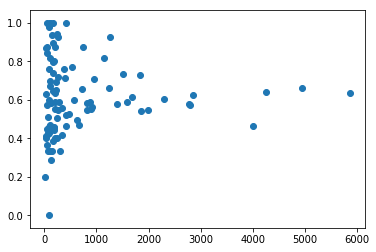

In [33]:
plt.scatter(repo_sizes, f1_scores)

# Doing NN things

In [15]:
curr = "edu.cmu.cs.hcii.cogtool.uimodel.GraphicalWidgetClipper"
candidates = ["org.eclipse.draw2d.geometry.Rectangle", "org.eclipse.swt.graphics.Rectangle"]
repo = 'cogtool/cogtool'

In [ ]:
G = build_graph(repo, rtc, import_g, export_g)

In [ ]:
class GatedGraphNeuralNetwork(nn.Module):
    def __init__(self, hidden_size, num_edge_types, layer_timesteps,
                 residual_connections,
                 state_to_message_dropout=0.3,
                 rnn_dropout=0.3,
                 use_bias_for_message_linear=True):

        super(GatedGraphNeuralNetwork, self).__init__()

        self.hidden_size = hidden_size
        self.num_edge_types = num_edge_types
        self.layer_timesteps = layer_timesteps
        self.residual_connections = residual_connections
        self.state_to_message_dropout = state_to_message_dropout
        self.rnn_dropout = rnn_dropout
        self.use_bias_for_message_linear = use_bias_for_message_linear

        # Prepare linear transformations from node states to messages, for each layer and each edge type
        # Prepare rnn cells for each layer
        self.state_to_message_linears = []
        self.rnn_cells = []
        for layer_idx in range(len(self.layer_timesteps)):
            state_to_msg_linears_cur_layer = []
            # Initiate a linear transformation for each edge type
            for edge_type_j in range(self.num_edge_types):
                # TODO: glorot_init?
                state_to_msg_linear_layer_i_type_j = nn.Linear(self.hidden_size, self.hidden_size, bias=use_bias_for_message_linear)
                setattr(self,
                        'state_to_message_linear_layer%d_type%d' % (layer_idx, edge_type_j),
                        state_to_msg_linear_layer_i_type_j)

                state_to_msg_linears_cur_layer.append(state_to_msg_linear_layer_i_type_j)
            self.state_to_message_linears.append(state_to_msg_linears_cur_layer)

            layer_residual_connections = self.residual_connections.get(layer_idx, [])
            rnn_cell_layer_i = nn.GRUCell(self.hidden_size * (1 + len(layer_residual_connections)), self.hidden_size)
            setattr(self, 'rnn_cell_layer%d' % layer_idx, rnn_cell_layer_i)
            self.rnn_cells.append(rnn_cell_layer_i)

        self.state_to_message_dropout_layer = nn.Dropout(self.state_to_message_dropout)
        self.rnn_dropout_layer = nn.Dropout(self.rnn_dropout)

    @property
    def device(self):
        return self.rnn_cells[0].weight_hh.device

    def forward(self,
                initial_node_representation: Variable,
                adjacency_lists: List[AdjacencyList],
                return_all_states=False) -> Variable:
        return self.compute_node_representations(initial_node_representation, adjacency_lists,
                                                 return_all_states=return_all_states)

    def compute_node_representations(self,
                                     initial_node_representation: Variable,
                                     adjacency_lists: List[AdjacencyList],
                                     return_all_states=False) -> Variable:
        # If the dimension of initial node embedding is smaller, then perform padding first
        # one entry per layer (final state of that layer), shape: number of nodes in batch v x D
        init_node_repr_size = initial_node_representation.size(1)
        device = adjacency_lists[0].data.device
        if init_node_repr_size < self.hidden_size:
            pad_size = self.hidden_size - init_node_repr_size
            zero_pads = torch.zeros(initial_node_representation.size(0), pad_size, dtype=torch.float, device=device)
            initial_node_representation = torch.cat([initial_node_representation, zero_pads], dim=-1)
        node_states_per_layer = [initial_node_representation]

        node_num = initial_node_representation.size(0)

        message_targets = []  # list of tensors of message targets of shape [E]
        for edge_type_idx, adjacency_list_for_edge_type in enumerate(adjacency_lists):
            if adjacency_list_for_edge_type.edge_num > 0:
                edge_targets = adjacency_list_for_edge_type[:, 1]
                message_targets.append(edge_targets)
        message_targets = torch.cat(message_targets, dim=0)  # Shape [M]

        # sparse matrix of shape [V, M]
        # incoming_msg_sparse_matrix = self.get_incoming_message_sparse_matrix(adjacency_lists).to(device)
        for layer_idx, num_timesteps in enumerate(self.layer_timesteps):
            # Used shape abbreviations:
            #   V ~ number of nodes
            #   D ~ state dimension
            #   E ~ number of edges of current type
            #   M ~ number of messages (sum of all E)

            # Extract residual messages, if any:
            layer_residual_connections = self.residual_connections.get(layer_idx, [])
            # List[(V, D)]
            layer_residual_states: List[torch.FloatTensor] = [node_states_per_layer[residual_layer_idx]
                                                              for residual_layer_idx in layer_residual_connections]

            # Record new states for this layer. Initialised to last state, but will be updated below:
            node_states_for_this_layer = node_states_per_layer[-1]
            # For each message propagation step
            for t in range(num_timesteps):
                messages: List[torch.FloatTensor] = []  # list of tensors of messages of shape [E, D]
                message_source_states: List[torch.FloatTensor] = []  # list of tensors of edge source states of shape [E, D]

                # Collect incoming messages per edge type
                for edge_type_idx, adjacency_list_for_edge_type in enumerate(adjacency_lists):
                    if adjacency_list_for_edge_type.edge_num > 0:
                        # shape [E]
                        edge_sources = adjacency_list_for_edge_type[:, 0]
                        # shape [E, D]
                        edge_source_states = node_states_for_this_layer[edge_sources]

                        f_state_to_message = self.state_to_message_linears[layer_idx][edge_type_idx]
                        # Shape [E, D]
                        all_messages_for_edge_type = self.state_to_message_dropout_layer(f_state_to_message(edge_source_states))

                        messages.append(all_messages_for_edge_type)
                        message_source_states.append(edge_source_states)

                # shape [M, D]
                messages: torch.FloatTensor = torch.cat(messages, dim=0)

                # Sum up messages that go to the same target node
                # shape [V, D]
                incoming_messages = torch.zeros(node_num, messages.size(1), device=device)
                incoming_messages = incoming_messages.scatter_add_(0,
                                                                   message_targets.unsqueeze(-1).expand_as(messages),
                                                                   messages)

                # shape [V, D * (1 + num of residual connections)]
                incoming_information = torch.cat(layer_residual_states + [incoming_messages], dim=-1)

                # pass updated vertex features into RNN cell
                # Shape [V, D]
                updated_node_states = self.rnn_cells[layer_idx](incoming_information, node_states_for_this_layer)
                updated_node_states = self.rnn_dropout_layer(updated_node_states)
                node_states_for_this_layer = updated_node_states

            node_states_per_layer.append(node_states_for_this_layer)

        if return_all_states:
            return node_states_per_layer[1:]
        else:
            node_states_for_last_layer = node_states_per_layer[-1]
            return node_states_for_last_layer

In [ ]:
node_to_id = {}
node_to_id[curr] = 0
for i in range(len(candidates)):
    node_to_id[candidates[i]] = i + 1
ind = len(candidates) + 1
for node in G.nodes:
    if node not in node_to_id:
        node_to_id[node] = ind
        ind += 1

In [ ]:
class AdjacencyList:
    """represent the topology of a graph"""
    def __init__(self, node_num: int, adj_list: List, device: torch.device):
        self.node_num = node_num
        self.data = torch.tensor(adj_list, dtype=torch.long, device=device)
        self.edge_num = len(adj_list)

    @property
    def device(self):
        return self.data.device

    def __getitem__(self, item):
        return self.data[item]

In [ ]:
def get_adjacency_list(G, node_to_id, gnn, candidate=None):
    adj_list = [(node_to_id[edge[0]], node_to_id[edge[1]]) 
                for edge in G.edges 
                if (edge[0] != curr or edge[1] not in candidates)]
    if candidate is not None:
        adj_list.append((node_to_id[curr], node_to_id[candidate]))

In [ ]:
def get_curr_embedding(G, node_to_id, seed, candidate=None, embed_size=10):
    torch.manual_seed(seed)
    gnn = GatedGraphNeuralNetwork(hidden_size=embed_size, 
                              num_edge_types=1,
                              layer_timesteps=[3, 5, 7, 2], 
                              residual_connections={2: [0], 3: [0, 1]})
    adj_list = get_adjacency_list(G, node_to_id, gnn, candidate=candidate)
    node_representations = gnn.compute_node_representations(torch.randn(len(G.nodes), embed_size),
                                                            adjacency_lists=[adj_list_type1])
    return node_representations[0]

In [ ]:
for candidate in [None] + candidates:
    print(get_curr_embedding(G, node_to_id, 610, candidate))

# Visualization and Old code

In [16]:
def build_tiny_graph(G, curr, candidates, repo, ctr, input_g, export_g, max_spread):
    """
    Build graph for preview
    """
    classes = [curr]
    distance = [0] * len(classes)
    edges = {}
    for x in classes:
        G.add_node(x)
    i = 0
    while len(classes) > i:
        
        if repo in ctr.get(classes[i], ''):
            lists = input_g.get(classes[i], {}).keys()
        else:
            lists = export_g.get(classes[i], {}).keys()
        
        for y in lists:
            if y in candidates and classes[i] == curr:
                continue
            if repo not in ctr.get(classes[i], '') and repo not in ctr.get(y, ''):
                # print(y)
                continue
            if y not in classes:
                if distance[i] + 1 >= max_spread:
                    continue
                classes.append(y)
                distance.append(distance[i] + 1)
                G.add_node(y)
            if not edges.get(y, {}).get(classes[i], False) and not edges.get(classes[i], {}).get(y, False):
                G.add_edge(classes[i], y)
                if y not in edges:
                    edges[y] = {}
                edges[y][classes[i]] = True
            
        i+=1
    return G, classes

In [22]:
def plot_graph(G, candidates, classes):
    pos=nx.spring_layout(G)
    plt.figure(figsize = (50,50))
    nx.draw_networkx_nodes(G,pos,
                       nodelist=classes[1:],
                       node_color='r',
                       node_size=30,
                   alpha=1)
    nx.draw_networkx_nodes(G,pos,
                       nodelist=[x for x in candidates if x in classes],
                       node_color='b',
                       node_size=400,
                   alpha=1)
    nx.draw_networkx_nodes(G,pos,
                       nodelist=classes[0:1],
                       node_color='g',
                       node_size=400,
                   alpha=1)
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    plt.axis('off')
    plt.show()

In [ ]:
def prune_graph(G, classes):
    count = 1
    while count > 0:
        degree = dict(G.degree())
        count = 0
        for x in degree.keys():
            if degree[x] == 1:
                classes.remove(x)
                G.remove_node(x)
                count += 1
        print(count)
    return G, classes

In [20]:
G=nx.Graph()
G, classes = build_tiny_graph(G, curr, candidates, repo, ctr, import_g, export_g, 4)
len(G.nodes())

522

In [ ]:
G, classes = prune_graph(G, classes)
len(G.nodes())

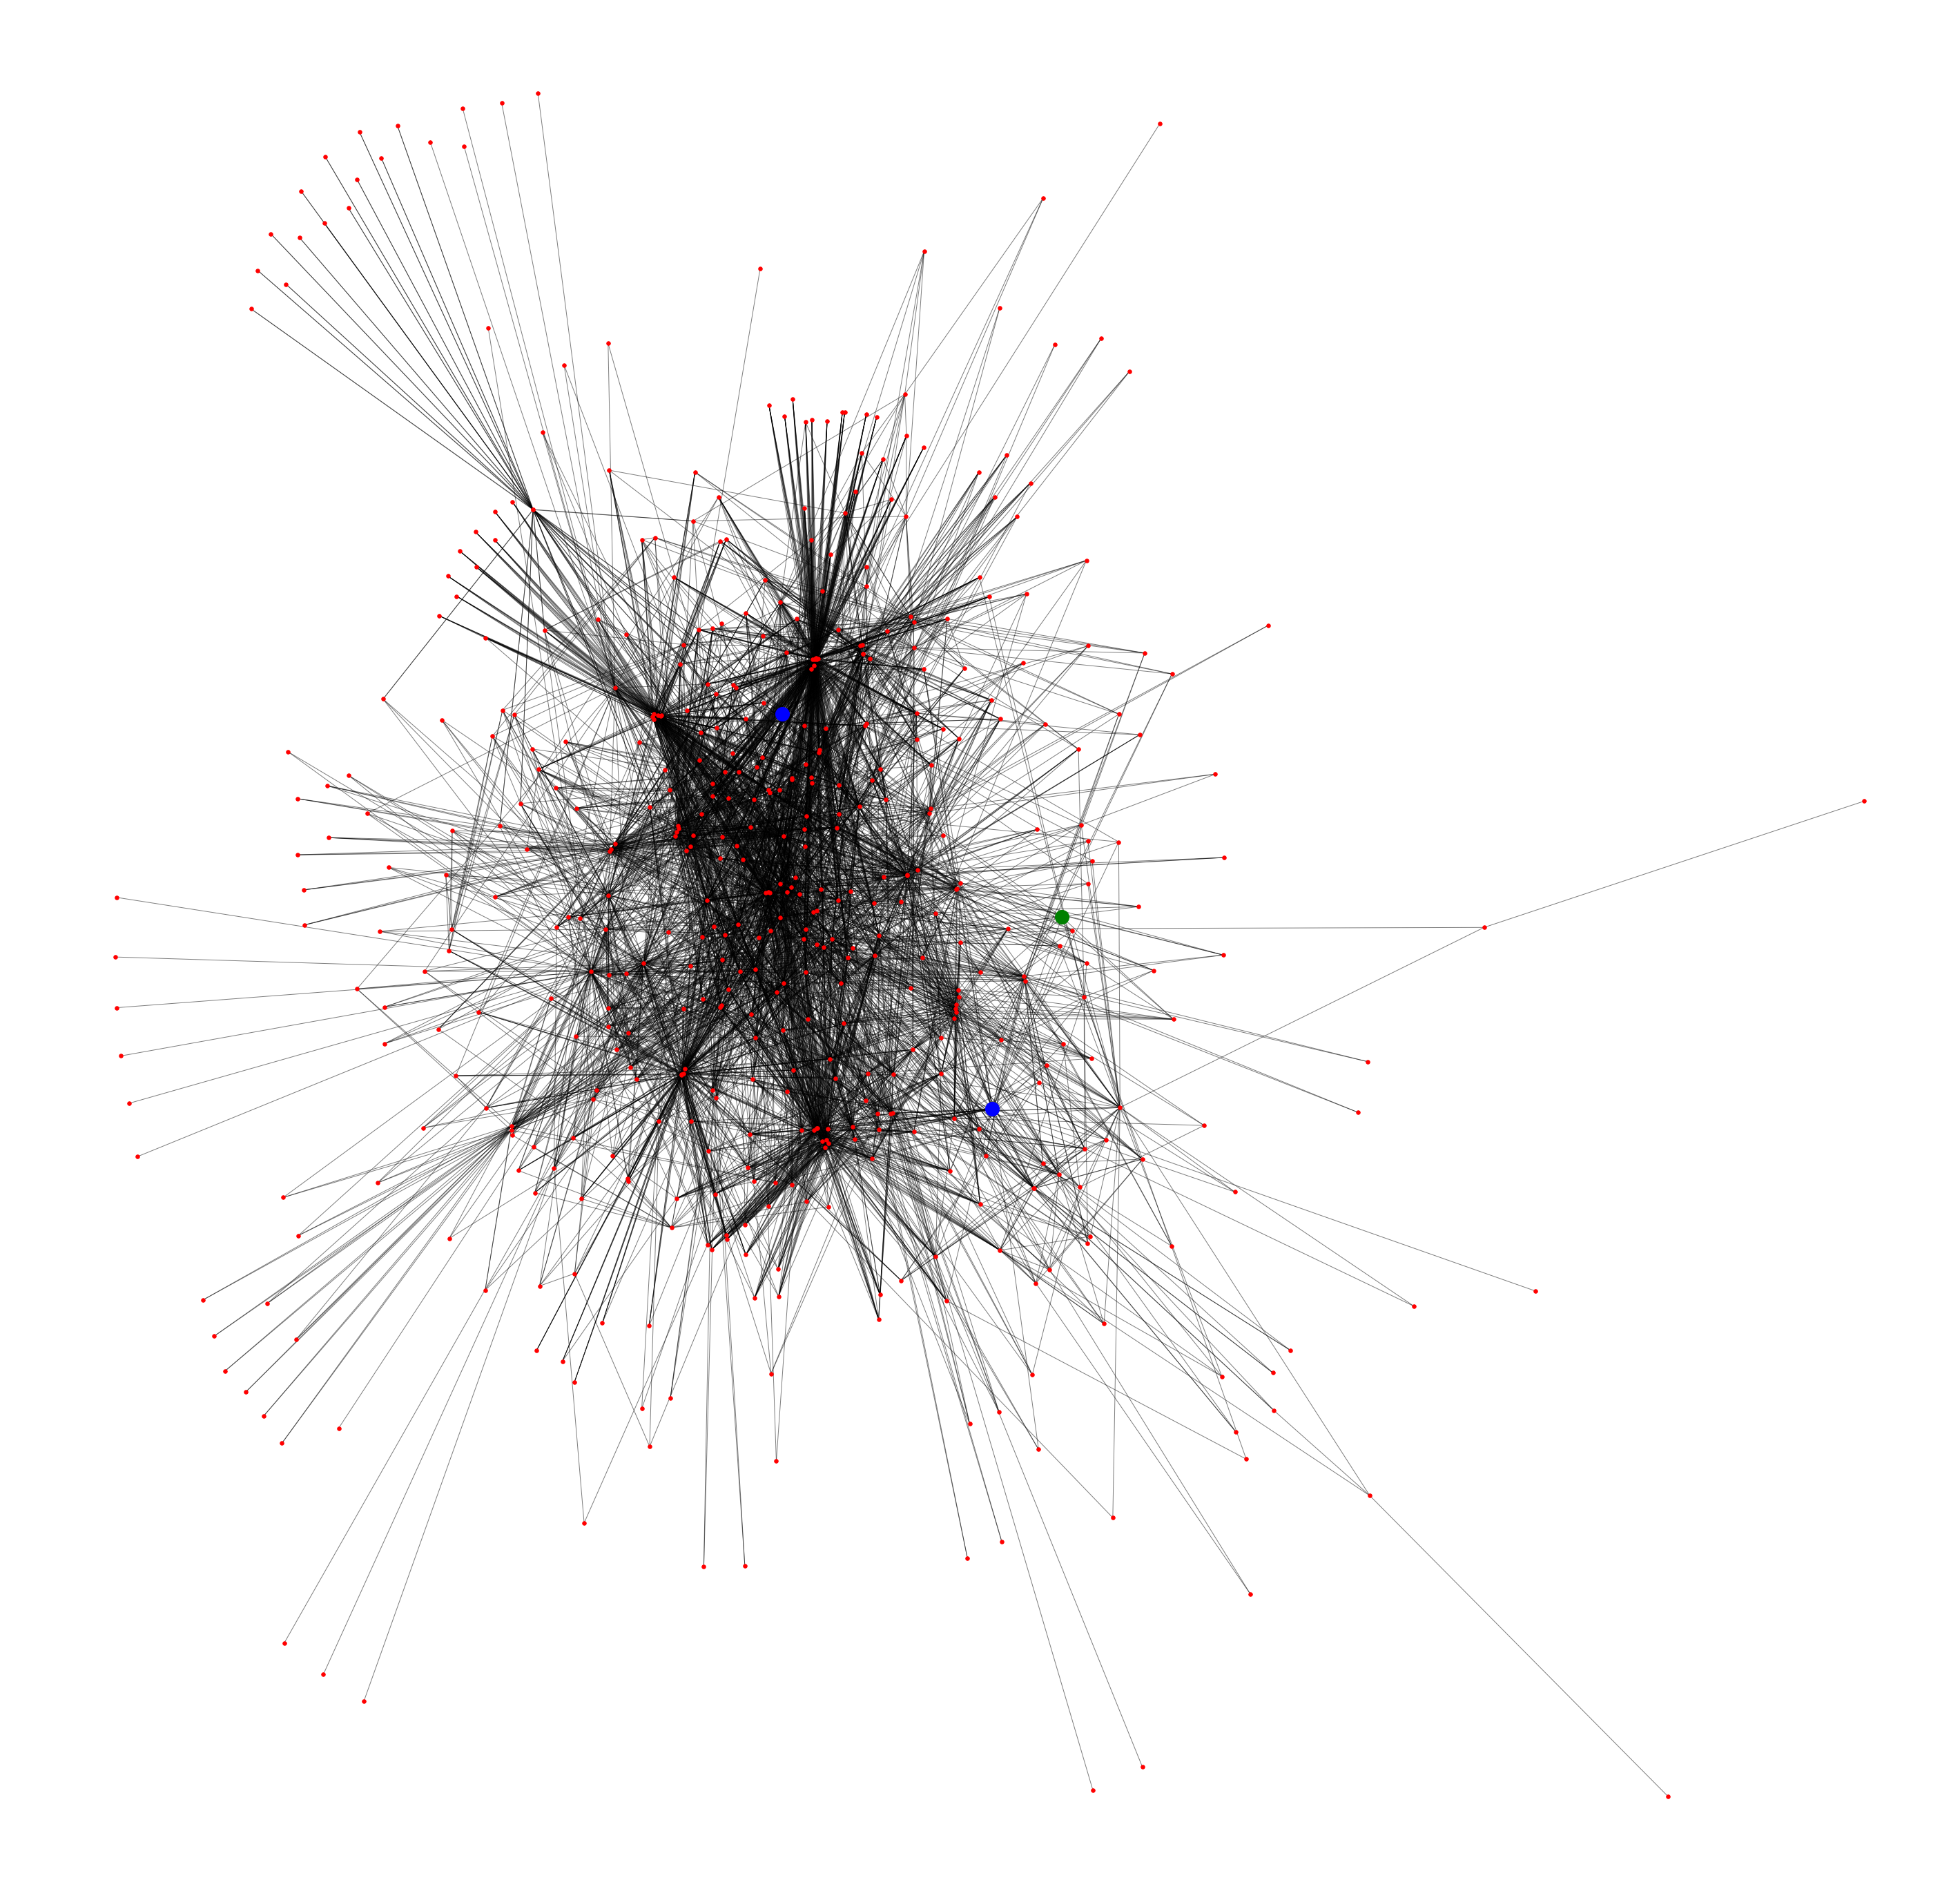

In [23]:
plot_graph(G, candidates, classes)

In [ ]:
len(list(nx.all_simple_paths(G, curr, candidates[0], cutoff=5)))

In [ ]:
len(list(nx.all_simple_paths(G, curr, candidates[1], cutoff=5)))

In [ ]:
nx.write_gexf(G, "test.gexf")